# Text Recommendations

In [1]:
import collections
import json
import numpy as np
import pandas as pd
import nltk
import matplotlib.pyplot as plt
from nltk.book import text6
from scipy import stats

*** Introductory Examples for the NLTK Book ***
Loading text1, ..., text9 and sent1, ..., sent9
Type the name of the text or sentence to view it.
Type: 'texts()' or 'sents()' to list the materials.


text1: Moby Dick by Herman Melville 1851


text2: Sense and Sensibility by Jane Austen 1811
text3: The Book of Genesis


text4: Inaugural Address Corpus


text5: Chat Corpus
text6: Monty Python and the Holy Grail


text7: Wall Street Journal
text8: Personals Corpus
text9: The Man Who Was Thursday by G . K . Chesterton 1908


The purpose of this notebook is two-fold create data for our text recommender application and generate sentences using the text data from Monty Python and the Holy Grail.

We will base this on word pairs aka bigrams. For example, the sentence "This is a sentence" has the following word pairs (This, is), (is, a) and (a, sentence). So for every word mentioned in the Monty Python and the Holy Grail, I'ld like to get a list of the words that followed that word and how often those words were mentioned. To do this I am going to create a dictionary whose keywords are the words and the items are named tuples. The named tuples will have a list of words that occurced after the keyword and a list the number of times it was used.

For example, suppose we were only analyzing the text that read as follows.

"Hello world. Hello world. Why hello there." 

The word "hello" would have two lists ['world', 'there'] and [2,1] because the word "world" succeeds "hello" twice in the text while "there" succeeds "hello" once.

In [2]:
Word = collections.namedtuple("Word", ['after_words','counts'])
WordProb = collections.namedtuple("Word", ['after_words','probs'])

We need to write some functions to clean the text and omit certain text. The text has already been tokenized. However, the text has been split by punctuation.  So words like "it's" have been split into (it, ') and (',s). So we will join all the tokens and then clean up the text some more.


In [39]:
text = ' '.join(text6.tokens)
#This should take care of the apostrophes
text = text.replace(" ' ", "'")
text[:100]

'SCENE 1 : [ wind ] [ clop clop clop ] KING ARTHUR : Whoa there ! [ clop clop clop ] SOLDIER # 1 : Ha'

In [42]:
"it's" in text #Test this out by commengint out the replace method in the block above.

True

Now, I am going to write a function that returns True if the text is a text that I want to omit. As of right now I am only elminating some punctuation marks.

In [43]:
#Returns True for text we want to omit and False otherwise
def omit_text(text):
    
    #Eliminate these marks for now as I don't think they will be meaningful
    is_a_mark = text in ["_", "$", "#", ";", ",", "]", 
                         "[", "{", "}", "", " ", ":", 
                         "!", "'", ".", '--', '?', '...']
    
    #You can add more conditions. In previous commits I eliminated numbers, but I decided to loosen up a bit.
    
    answer = True if is_a_mark else False
    
    return answer

In [44]:
omit_text(" ")

True

In [45]:
all_words = text.split(" ")
words = [w for w in all_words if not omit_text(w)]

words[:5]

['SCENE', '1', 'wind', 'clop', 'clop']

In [46]:
word_counts =pd.Series(words).value_counts()

word_counts[:10]

the       298
ARTHUR    225
I         203
you       188
a         187
of        158
to        142
and       133
Oh        110
is        100
dtype: int64

In [47]:
bigrams = [b for b in zip(words[:-1], words[1:])]

bigrams[:5]

[('SCENE', '1'),
 ('1', 'wind'),
 ('wind', 'clop'),
 ('clop', 'clop'),
 ('clop', 'clop')]

In [49]:
word_dict = {}

for word in list(set(words)):
    all_words_after = [w[1] for w in bigrams if w[0] == word]
    word_counts = pd.Series(all_words_after).value_counts()
    
    word_dict[word] = Word(after_words=word_counts.index.tolist(), counts=word_counts.tolist())

In [52]:
word_dict["King"]

Word(after_words=['Arthur', 'of', "Arthur's", 'you', 'who'], counts=[15, 9, 1, 1, 1])

Now, we need to save the data.

In [53]:
with open("data/monty_python_holy_grail_word_data.json", "w") as file:
    json.dump(word_dict, file)

### Sentences
Next I'd like to know how long each sentence is usually in words. To do this I will write a simple function to count number of words in a sentence.

In [54]:
def num_words(text_dum):
    
    word_list = text_dum.split(" ")
    
    return len(word_list)

In [55]:
sentences = nltk.sent_tokenize(text)

sent_length = np.array([num_words(sent) for sent in sentences])

print(sent_length[:5])

stats.describe(sent_length)

[17 11  4 19 15]


DescribeResult(nobs=1882, minmax=(1, 116), mean=8.5712008501594052, variance=56.189770912322501, skewness=3.7646419885765847, kurtosis=30.017681161161036)

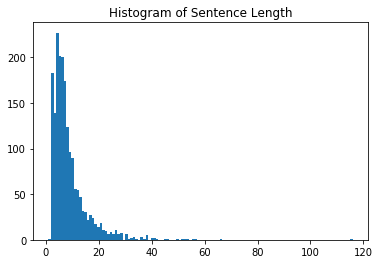

In [57]:
plt.hist(sent_length, bins='auto',)
plt.title("Histogram of Sentence Length")
plt.show()

So the sentence length varies quite widely. The mean is about 9 and the variance is about 60. Next I would like to know which words commonly start a sentence.

In [59]:
start_words = [x.split(" ")[0] for x in sentences if not omit_text(x.split(" ")[0])]

starts = pd.Series(start_words).value_counts()/sum(pd.Series(start_words).value_counts())

starts[:10]

ARTHUR       0.103408
LAUNCELOT    0.035817
GALAHAD      0.035817
BEDEVERE     0.026574
I            0.025997
VILLAGER     0.025419
FATHER       0.024841
ROBIN        0.019064
GUARD        0.016753
KNIGHTS      0.016753
dtype: float64

Next I would like to create a function that randomly picks a start word according to these probabilities.

In [60]:
prob_starts = starts.tolist()

sent_starts = starts.index.tolist()

def start_sentence(sent_starters=sent_starts, prob=prob_starts):
    return np.random.choice(sent_starters, p=prob)

In [62]:
start_sentence(sent_starts, prob_starts)

'FATHER'

Next, I would like to write  a function that picks the subsequent word at random according to the probabilities derieved from the word counts in word_dict.

In [63]:
def scale1(x):
    x = np.array(x)
    
    return list(x/x.sum())

In [64]:
prob_dict = {}

for key,val in word_dict.items():
    after_words, counts = word_dict[key]
    probs = scale1(counts)
    
    prob_dict[key] = WordProb(after_words=after_words, probs=probs)

Next let's write a function that generates the next word.

In [65]:
def next_word(last_word, word_data):
    word = word_data[last_word]
    
    return np.random.choice(word.after_words, p=word.probs)

In [67]:
next_word('ARTHUR', prob_dict)

'How'

In [68]:
def generate_sentence(num_words):
    
    last_word = start_sentence()
    
    sent = last_word
    
    sent_length = len(sent.split(' '))
    
    while sent_length <= num_words:
        last_word = next_word(last_word, prob_dict)
        sent += " " + last_word
        sent_length = len(sent.split(' '))
        
    sent = sent + "."
    
    return sent

In [69]:
generate_sentence(7)

"Supreme executive power just'cause some lovely acting in."

For simplicity, I will generate the length of sentence randomly from a poisson distribution despite the fact that given our histrogram and summary statistics are not consistent with the poisson distribution because the mean and variance are far apart.

In [70]:
nums = np.random.poisson(lam=9, size=100)

sim_text = [generate_sentence(num) for num in nums]

sim_text[:5]

['ARTHUR You tit I shall snuff it GUARD Of course not afraid of.',
 'ARTHUR If you have a little bit daft to.',
 'GUARD 2 Burn BEDEVERE My God dramatic chord ARTHUR.',
 "OLD MAN Seek you Oh yes We'll stay.",
 'ARTHUR Brave brave and I.']

In [72]:
pd.DataFrame({'sentence':sim_text}).to_csv("simulated_sentences.csv", index=False)